In [1]:
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
import xarray
import numpy as np
from pyeosim.datasets import DATA_PATHS
from pyeosim.sensor import TeledyneCMOS
from pyeosim.postprocess import CmosReflectance
from pyeosim.atmosphere import Test6S
from pyeosim.plot import rgb
from pyeosim.measure import NDVI
from sklearn import linear_model

In [2]:
# load and preprocess imagery
fpath = DATA_PATHS['TEST_HSI_LARGE']
im = xarray.open_dataset(fpath).Reflectance
im = im.swap_dims({'band':'wavelength'})
im_ref = im.sel(wavelength=slice(400,898)).astype(float)/10000

In [3]:
atmos = Test6S()
# generate Top of Atmosphere images
TOA = atmos.transform(im_ref).compute()
TOA_ref = atmos.transform(xarray.ones_like(im_ref))

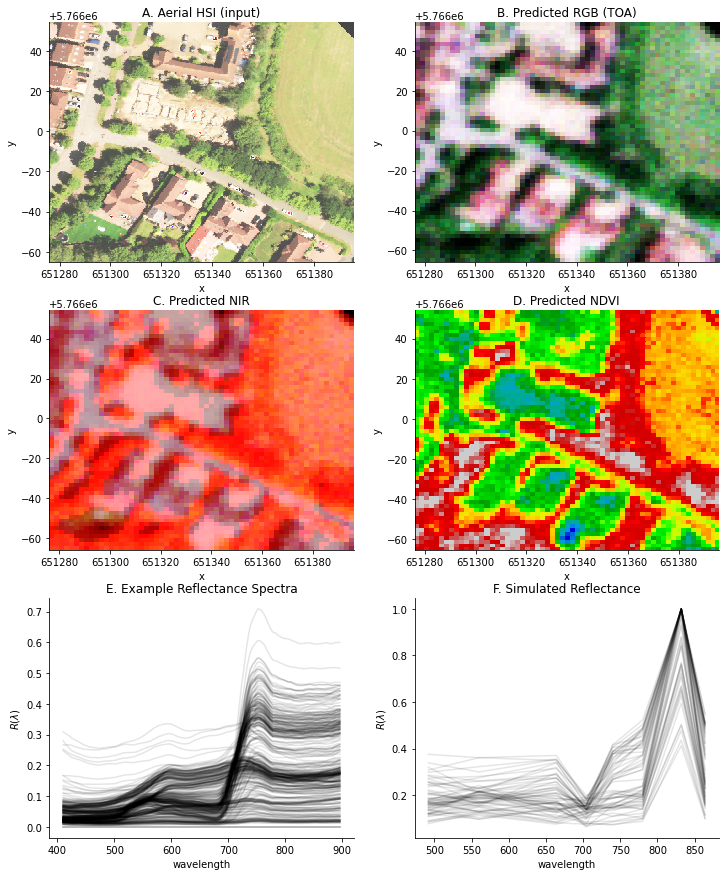

In [25]:
cmos = TeledyneCMOS(integration_time=.001,
                    sense_node_gain=5,
                    dark_current=5,
                    ccd_vref=3.1,
                    adc_gain=2000000,
                    adc_vref=3.1,
                    dark_factor=.1,
                    offset_factor=.001,
                    full_well=1e5,
                    store_steps=True)

cmos_pipe = CmosReflectance(cmos, TOA_ref)
out_r = cmos_pipe.fit_transform(TOA)
sensor_wlen = list(cmos.spectral_response.band_wavelengths.values())
out_rp = out_r.assign_coords(
    wavelength = ('band', sensor_wlen)
).swap_dims({'band': 'wavelength'})

rgb_orig = im.isel(wavelength=[70,40,20]).swap_dims({'wavelength':'band'})
bgr = out_r.isel(band=[2,1,0])
nir = out_r.isel(band=[6,1,0])
ndvi = ((out_r.isel(band=6) - out_r.isel(band=2))/(out_r.isel(band=6) + out_r.isel(band=2)))

fig, ax = plt.subplots(3,2, figsize=(12,15))

rgb(rgb_orig,ax=ax[0][0])
ax[0][0].set_title('A. Aerial HSI (input)')

rgb(bgr,ax=ax[0][1])
ax[0][1].set_title('B. Predicted RGB (TOA)')

rgb(nir,ax=ax[1][0])
ax[1][0].set_title('C. Predicted NIR')

ndvi.plot(ax=ax[1][1], add_colorbar=False, robust=True, vmin=0, cmap='nipy_spectral')
ax[1][1].set_title('D. Predicted NDVI')

im_ref.isel(y=20).plot(hue='x', c='k', alpha=.1, add_legend=False, ax=ax[2][0])
ax[2][0].set_title('E. Example Reflectance Spectra')
ax[2][0].set_ylabel(r'$R(\lambda)$')

out_rp.isel(y=4).plot(hue='x', c='k', alpha=.1, add_legend=False, ax=ax[2][1])
ax[2][1].set_title('F. Simulated Reflectance')
ax[2][1].set_ylabel(r'$R(\lambda)$')
sns.despine()

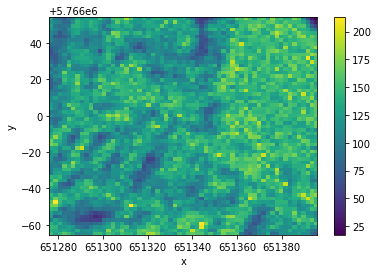

In [27]:
im_rep10 = xarray.concat([TOA]*10, dim='repeat')
snr_1 = cmos.transform(im_rep10)
snr = snr_1.mean('repeat')/snr_1.std('repeat')

snr.sum('band').plot()

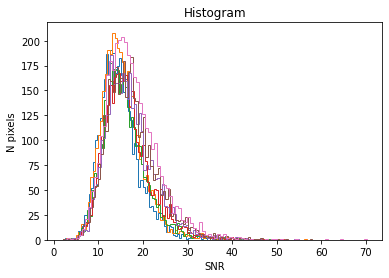

In [28]:
snr.isel(band=1).plot.hist(histtype='step',bins=100)
snr.isel(band=2).plot.hist(histtype='step',bins=100)
snr.isel(band=3).plot.hist(histtype='step',bins=100)
snr.isel(band=4).plot.hist(histtype='step',bins=100)
snr.isel(band=5).plot.hist(histtype='step',bins=100)
snr.isel(band=6).plot.hist(histtype='step',bins=100)
snr.isel(band=7).plot.hist(histtype='step',bins=100)
plt.xlabel('SNR')
plt.ylabel('N pixels')
plt.show()

Text(0.5, 1.0, 'Band 2')

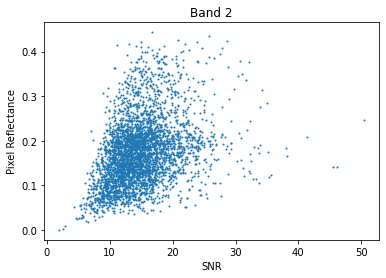

In [31]:
_snr1 = snr.isel(band=1).values.ravel()
_out_1 = out_r.isel(band=1).values.ravel()
plt.scatter(_snr1, _out_1,s=1)
plt.xlabel('SNR')
plt.ylabel('Pixel Reflectance')
plt.title('Band 2')

Text(0.5, 1.0, 'Band 8')

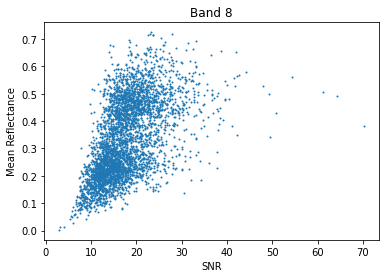

In [32]:
_snr7 = snr.isel(band=7).values.ravel()
_out_7 = out_r.isel(band=7).values.ravel()
plt.scatter(_snr7, _out_7,s=1)
plt.xlabel('SNR')
plt.ylabel('Mean Reflectance')
plt.title('Band 8')